# What does it take to become an NBA All-Star?

## Introduction

The NBA All-Star game is an exhibition game hosted every season which showcases twenty-four “All-Star” basketball players chosen through popular vote between players, fans, and media. This process means a player can be voted an All-Star for things other than their basketball skills; the consequence of this format is that voting may turn into a popularity contest. This project aims to leverage player statistics and perform classification analysis on how a player’s individual stats correlate with that player being voted an All-Star. A model will be created to identify and classify players as All-Stars using the K-nearest neighbours algorithm; the datasets we will be using contain the culminated individual season statistics of all NBA players from the three seasons of basketball played between 2017 and 2020. These datasets are from [nbastuffer.com](https://www.nbastuffer.com) and Bryan Polvinski’s player game logs in [data.world](https://www.data.world/bpovlins/nba-player-game-logs/workspace/file?filename=2017-2018+NBA+Game+Log.xlsx.). This project answers the question “Do player statistics determine the All-Star classification of a player?” 


## Methods and Results

Initially, we wanted a single data source that contains all of the needed statistics from the NBA over the past three years; however, we were not able to find a suitable dataset that encompasses all three years. Instead, we found three separate datasets that are subsets of the desired observations. Each one of the three datasets contains one season’s player statistics, and putting them together created our desired data using Excel. For one of the seasons, we created a web-scraper with Python to collect the data. This was done as the website we were using had not yet created the “Download” button for the most recent NBA season. Since the data were obtained in different ways and were originally in different formats, we had to do a bit of cleaning to have the required rows and columns. 
$$ $$
After merging our datasets, we uploaded the centralized data onto Github in which we used the link to the raw .csv file to download to the Jupyter Notebook. However, before reading our .csv file we loaded the following libraries: tidymodels and tidyverse, and set the seed at the start of the Notebook to get consistent results. We chose tidyverse because it allows us to use the tidyverse functions such as `mutate`, `select`, and `filter` to help us wrangle and clean the data while also providing us with `ggplot` - which gives us the ability to graph our data neatly. Moreover, tidymodels is used to model and classify our cleaned data, using functions such as `workflow`, `recipe`, and `nearest_neighbors`.

In [1]:
# Loading in the needed libraries
library(tidyverse)
library(tidymodels)

# Set seed
set.seed(100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.8      ✔ rsample   0.0.7 
✔ infer     0.5.3      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.1.3 
✔ parsnip   0.1.3    

Next, we loaded the data from our Github account to the Jupyter Notebook using the `read_csv` function from tidyverse by passing it the appropriate URL. 

In [2]:
data_route <- "https://raw.githubusercontent.com/PrayusShrestha/DSCI100/main/DSCI100%20-%20Sheet1.csv"

# Loading data from GitHub
data <- url(data_route) %>%
        read_csv(col_names = TRUE, na = c('', 'NA')) 

Parsed with column specification:
cols(
  .default = col_double(),
  RANK = col_logical(),
  `FULL NAME` = col_character(),
  TEAM = col_character(),
  POS = col_character()
)

See spec(...) for full column specifications.



We then proceeded to filter out the unnecessary columns by using the `select` function, keeping only the columns Status, Points Per Game (PPG), and Minutes Per Game (MPG). After, we numbered the rows from the first to the 1877th, using the mutate function. This was necessary for an easier access to a specific row or observation. The Status column was previously populated by 0's and 1's, with a 0 representing a normal All-Star player, and 1 being an All-Star player. We then converted each number in the Status column to according to this legend:
- 0 becomes “Normal”, meaning a normal NBA player
- 1 becomes “All_Star”, meaning a NBA All-Stars

We did this for the purpose of giving human-readable label names by vectorizing `if` and `else if` statements using the `case_when` function. Since the Status column was not a factor for classification, we mutated the Status column to factors using the `as_factor` function.

In [3]:
# Data cleaning and wrangling 
tidied_data <- data %>%
     mutate(n = seq(1, 1877)) %>% 
    select(n, Status, PPG, MPG) %>%
    mutate(Status = case_when(Status == 0 ~ "Normal", Status == 1 ~ "All_Star")) %>%
    mutate(Status = as_factor(Status)) 
head(tidied_data)

n,Status,PPG,MPG
<int>,<fct>,<dbl>,<dbl>
1,Normal,5.3,19.0
2,Normal,1.7,12.3
3,Normal,3.2,12.6
4,Normal,13.9,33.4
5,Normal,8.9,23.3
6,Normal,1.7,10.2


After, we split the data into training and testing sets with a proportion of 75% training data and 25% testing data. This was done because we wanted to train an accurate model by passing it enough data while still keeping the size of the testing data adequate. By allocating 75% of the data to the training set, we’re allowing for the model to be fitted and “learn from” a sufficient amount of data. The leftover 25% is still large enough for us to adequately test our model with unseen data and get a meaningful result. 

In [4]:
# Splits
player_split <- initial_split(tidied_data, prop = 0.75, Strata = Status)
player_training <- training(player_split)
player_testing <- testing(player_split)

We visualized the training data using a scatter plot with human-readable labels in order to confirm that everything was working as intended using the ggplot function. We can see that the MPG and PPG have a positive relationship; this makes sense as basketball players who play more minutes get more opportunities to score and will have a higher PPG. Another thing to note is the colouring of the data points - a majority of the All-Star player data points are located in an area of relatively high MPG and PPG. This also makes sense as good basketball players (those of All-Star calibre) will be playing more minutes in a game and scoring more points.

In [5]:
# Visualization of all the players based on PPG and MPG with colouring based on All-Star Status
player_plot <- player_training %>%  
    ggplot(aes(x = MPG, y = PPG, color = Status)) + 
    geom_point(alpha = 0.5) +
    labs(color = "All-Star Status", x = "Minutes per Game (MPG)", y = "Points per Game (PPG)")  +
    ggtitle("Figure 1: Points per Game vs. Minutes per Game") +
    theme(text = element_text(size = 15))

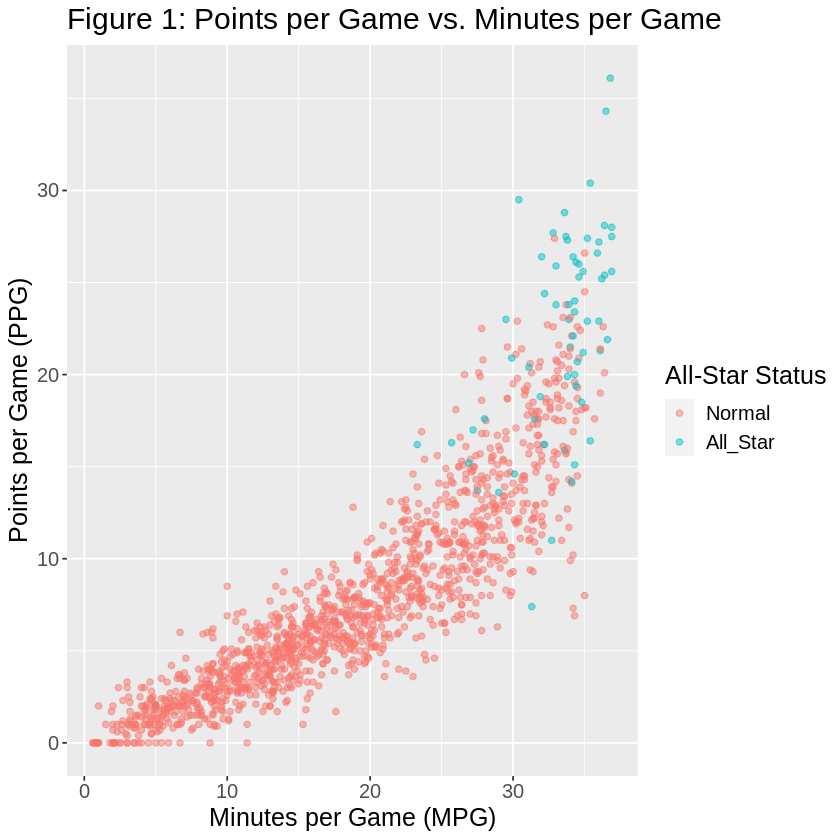

In [6]:
player_plot

In [7]:
# Count of all players in the training dataset based on All-Star Status
player_status_count <- player_training %>%
    group_by(Status) %>% 
    tally() %>%
    mutate(Count = n) %>%
    select(-n) 


print("Figure 2: Status Count")
player_status_count

[1] "Figure 2: Status Count"


Status,Count
<fct>,<int>
Normal,1345
All_Star,63


In our next step, we created a recipe using the training dataset. The target variable is the class variable of the status of the player (Status) and the predictor variables are PPG (Points per Game) and MPG (Minutes per Game). Since the class label of "Normal" is predominant in comparison to the “All_Star” class label, we helped balance out the data by oversampling the rare case - "All_Star" - using the `step_upsample`function with an oversampling ratio of 0.25. This helped combat the originally absurd ratio of "Normal" players to "All_Star" players (roughly 20:1 prior upsampling) that is seen in Figure 2 above. We also allowed the predictor variables to become comparable in the recipe by applying `step_scale` and `step_center` functions. This was done because our predictors did not have the scale, which would have resulted in one variable having a stronger impact during the nearest neighbor search.

We trained the model by creating a model specification of our training set. Firstly, we needed to find the optimal K value for our model; for this, we used the `tune` and `tune_grid` functions to find the best value of K. In our model, the straight-line distance of the point should be used by setting `weight_func` to be  `"rectangular"` in the argument. This makes all the neighbors to have the same voting power, regardless of their varying distances. Since we are classifying our predictors, we determined that we were using the “kknn” engine for the `set_engine` function and “classification” for the `set_mode` function. The training set is split into five chunks evenly by performing a 5-fold cross-validation to further increase our accuracy. Moreover, we set the `strata` argument to be “Status,” because that is the column (factor) that we are classifying.
$$$$
In order to find the best value of K, we created the dataframe `k_lots` to try different values of K, assigning the range of K using the tibble function with a neighbors variable, from 1 to 100. We assumed that anything over 100 would be underfitting because the number of "Normal" players may dominate the number of "All-Star" players. We then performed a workflow analysis and fit the model. By doing this, we specified the range of K that we wanted to test. After, we could use the `tune_grid` function after passing the workflow objects to `add_recipe` and `add_model` functions. For this step of using the `tune_grid` function, we specified that the tuning is supposed to try a range of different values of K that had been designated in the `k_lots` dataframe. 

In [8]:
# This cell and the following code cell are used to identify a good K value to use 

# Creating the recipe
player_recipe <- recipe(Status ~ PPG + MPG, data = player_training) %>%
           step_upsample(Status, over_ratio = 0.25, skip = TRUE) %>% 
           step_scale(all_predictors()) %>%
           step_center(all_predictors())

# Model Specifications
player_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                set_engine("kknn") %>%
                set_mode("classification")

player_vfold <- vfold_cv(player_training, v = 5, strata = Status)

k_lots = tibble(neighbors = seq(from = 1, to = 100, by = 10))

# Putting it all together in the workflow
player_fit <- workflow() %>%
    add_recipe(player_recipe) %>%
    add_model(player_model) %>%
    tune_grid(resamples = player_vfold, grid = k_lots)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


We then checked the varying accuracies of different K values by collecting metrics of the workflow analysis, passing the fit object `player_fit` that we created in the previous step, using the `collect_metrics` function. We filtered rows of “accuracy” from the `.metric` column by using the `filter` function. Lastly, we made a scatterplot of the accuracies to help us pick the best value of K.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9410641,5,0.005539932,Model01
11,accuracy,binary,0.9318038,5,0.007080721,Model02
21,accuracy,binary,0.9381868,5,0.010190372,Model03
31,accuracy,binary,0.9424623,5,0.004969627,Model04
41,accuracy,binary,0.9460110,5,0.004847997,Model05
51,accuracy,binary,0.9403296,5,0.004978120,Model06
61,accuracy,binary,0.9438808,5,0.004716638,Model07
71,accuracy,binary,0.9502663,5,0.005874127,Model08
81,accuracy,binary,0.9509780,5,0.005354083,Model09


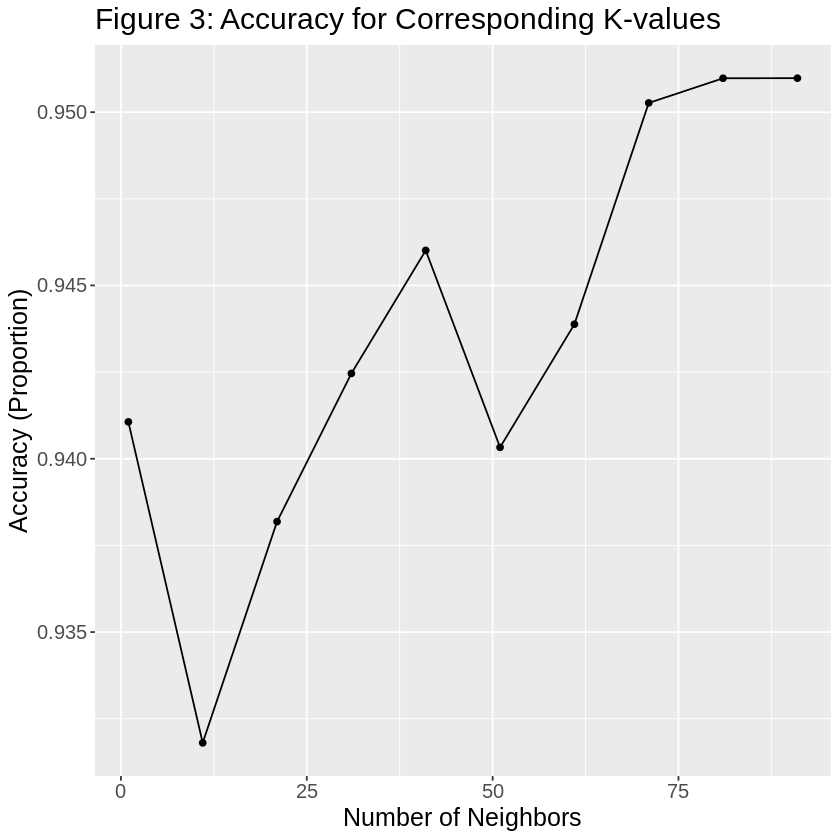

In [9]:
# Intermediate step to pull needed data used later in determining the optimal k value
player_accuracies <- player_fit %>%
     collect_metrics() %>%
     filter(.metric == "accuracy")

# Plotting the various model accuracies based on different k values
player_accuracies_plot <- player_accuracies %>%
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy (Proportion)", title = "Figure 3: Accuracy for Corresponding K-values") +
    theme(text = element_text(size = 15))

player_accuracies_plot
player_accuracies

From the visualization above, we can say that the best value of K is found to be 81. This is because K = 81 had a  high accuracy and also had both positive and negative limits, to be around the same high accuracy. 
$$$$
After we decided the best value of K, we created a new recipe and a new model, and we specified the value of K to be 81 in the `neighbors` argument. With the new recipe and new model, we fit them on our training dataset by using the `fit` function in the workflow analysis. Then we checked the predicted labels using the `prediction` function, and we added the column of the result of prediction to the test dataset with the `bind_cols` function. Next, we used the `metrics` functions to assess the quality of the model, specified the `Status` column in the `truth` argument and `.pred_class` in the estimate argument. We then used the `filter` and `select` functions to get the accuracy and printed it as a single vector using the pull function. 

In [10]:
# Creating the recipe
player_recipe <- recipe(Status ~ PPG + MPG, data = player_training) %>%
           step_upsample(Status, over_ratio = 0.25, skip = TRUE) %>%
           step_scale(all_predictors()) %>%
           step_center(all_predictors())

# Model specifications
player_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 81) %>%
                set_engine("kknn") %>%
                set_mode("classification")

# Putting it together in a workflow 
player_fit <- workflow() %>%
    add_recipe(player_recipe) %>%
    add_model(player_model) %>%
    fit(data = player_training)

player_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

● step_upsample()
● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~81, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1011303
Best kernel: rectangular
Best k: 81

The code cell below shows the change in ratio between the Normal and All_Star count in the Status column. From the originally one-sided ratio of 20:1, we've upsampled the data to a much more even ratio of 4:1. This was done to ensure that each side (both Normal and All_Star), would have sufficient voting power in the model when applying the K-nearest neighbors algorithm. 

In [11]:
# Seeing the results of upsampling to a ratio of 0.25
prep_upsample <- recipe(Status ~ PPG + MPG, data = player_training) %>%
    step_upsample(Status, over_ratio = 0.25, skip = FALSE) %>%
    prep()

player_bake <- bake(prep_upsample, player_training) 

player_status_count_post_scale <- player_bake %>% 
    group_by(Status) %>% 
    tally() %>%
    mutate(Count = n) %>%
    select(-n) 

print("Figure 4: Status Count After Upscaling")
player_status_count_post_scale

[1] "Figure 4: Status Count After Upscaling"


Status,Count
<fct>,<int>
Normal,1345
All_Star,336


In [12]:
# Applying the created model to the testing data
validation_predicted <- predict(player_fit, player_testing) %>%
                              bind_cols(player_testing)

model_accuracy <- validation_predicted %>% 
              metrics(truth = Status, estimate = .pred_class) %>%
              filter(.metric == "accuracy") %>%
              select(.estimate) %>%
              pull()

model_accuracy

[1] 0.9552239

Our model got an accuracy of ~95.5%. With the completed model, we then created a visualization of the predictions, with the value of K being 81. The scatterplot below shows training data points coloured according to their Status, and has the background colour set to be the model’s predicted Status for a given PPG and MPG. 

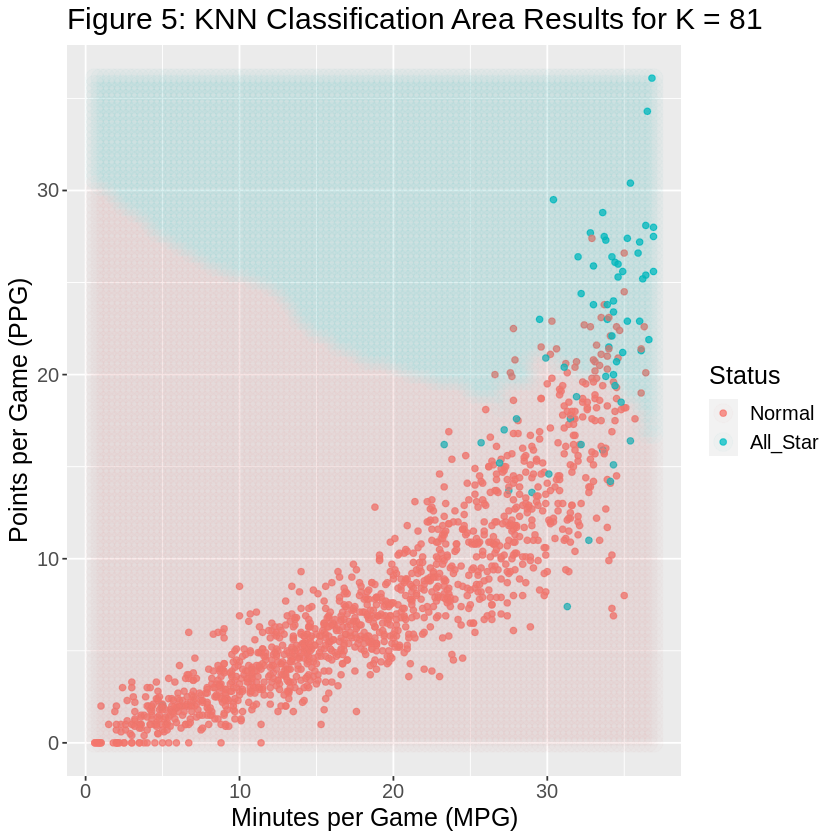

In [13]:
mpg_grid <- seq(min(player_training$MPG), max(player_training$MPG), length.out = 100)
ppg_grid <- seq(min(player_training$PPG), max(player_training$PPG), length.out = 100)


mpg_rank_grid <- expand.grid(MPG = mpg_grid, PPG = ppg_grid)
knnPredGrid <- predict(player_fit, new_data = mpg_rank_grid)


prediction_table <- bind_cols(knnPredGrid, mpg_rank_grid) %>% rename(Status = .pred_class)


k_81_plot <- ggplot() +
    geom_point(data = player_training, mapping = aes(x = MPG, y = PPG, color = Status), alpha = 0.75) +
    geom_point(data = prediction_table, mapping = aes(x = MPG, y = PPG, color = Status), alpha = 0.02, size = 5)+
    labs(x = "Minutes per Game (MPG)", y = "Points per Game (PPG)", color = "Status") +
    ggtitle("Figure 5: KNN Classification Area Results for K = 81") +
    theme(text = element_text(size = 15))
    

k_81_plot

## Discussion

The classification model we created predicted a player’s status based on the Minutes per Game (MPG) they played, and the Points per Game (PPG) they scored with 95.5% accuracy.  Since our model is quite accurate, it is reasonable to believe that a player’s selection to the All-Star game is related to their quantifiable basketball performance. Though they’re still selected by voters, this accurate model suggests the voters are influenced by a player’s statistics. 
$$$$ 
The visualization we have obtained from the analysis displayed the significance of the two variables on the predictive variable (All-Star Status). For the most part, a higher MPG and PPG allowed was associated with becoming an All-Star. Though we had a few outliers that were voted as All-Stars, these can be explained intuitively through the game of basketball: not all All-Stars dominate the game through scoring points and playing many minutes. Other factors and statistics can also influence the game and All-Star voting. Factors such as popularity, team performance, and assists per game may also play a role in determining the season’s All-Stars. These can be analyzed in further projects. The findings from those projects can be used to better explain the outliers found in our report. Another interesting set of data points to analyze further are the player's who scored lots of points and played a sizeable amount of minutes, yet still weren't voted to be an All-Star. Once again, this can be reasoned intuitively. One cause for this may have been related to injuries: though a player was playing great basketball (and maybe was en-route to be voted an All-Star), they might've gotten injured partway through the season. Their previous game statistics were still strong, but the injury may have caused them to miss becoming an All-Star selection that season. This can be another point of interest for future reports.
$$$$
This study can have a significant impact on all the people who love the game of basketball by giving us an idea of how the two variables act in accordance to the players’ chances of becoming an All-Star. For example, this study could give motivation to the players to score more points and play more minutes while it gives the scouts and employers to have an idea of what they could look for in a player in order to grow their franchise. These results could also give the fans an idea of what the odds are for their favourite players to make it to the All-Star week. Hence, the fans could root for their favourite players to score more points and play more minutes per game.
$$$$
The result was in fact what we have predicted, and this is because the players with All-Star status tend to have the most influence over the game. Therefore, it was expected for All-Star players to have higher points and minutes per game, but since the All-Star status is not merely based on the players' statistics, we wanted to make sure that PPG and MPG does in fact play a role in determining an All-Star. In the previous three NBA seasons, there were a number of players who contributed a lot of points and minutes while not being an All-Star, but we can clearly see from the visualization that although a few outliers exist, the two explanatory variables have a substantial influence over the status of the players. Thus, the study we have conducted was proven to be effective, and we can conclude that the points per game and minutes played per game had significant effects on the status of the players.

## References


NBA.com Staff. “NBA All-Star Draft: How It All Works.” NBA All-Star Draft: How It All Works | NBA.com, 25 Jan. 2020, 6:36AM, www.nba.com/nba-all-star-draft-explainer  $$$$
Povlinski, Bryan. NBA Player Game Logs, data.world, 2018, data.world/bpovlins/nba-player-game-logs/workspace/file?filename=2017-2018+NBA+Game+Log.xlsx. $$$$
“2018-2019 NBA Player Stats.” 13th Anniversary, 2019, www.nbastuffer.com/2018-2019-nba-player-stats/ $$$$
“2019-2020 NBA Player Stats.” 13th Anniversary, 2020, www.nbastuffer.com/2019-2020-nba-player-stats/ $$$$
Wright, Michael C. “How Much Does an All-Star Selection Mean to Players?” How Much Does an All-Star Selection Mean to Players? | NBA.com, NBA ALL-STAR 2020, 29 Jan. 2020, 6:59 AM, www.nba.com/news/what-all-star-selections-mean-players. $$$$
